<a href="https://colab.research.google.com/github/seymadogru/BasicDataTypes/blob/master/Warehouse_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import gym
from gym import spaces
import numpy as np
import time
from IPython.display import clear_output

class CVRPLogisticsEnv(gym.Env):
    def __init__(self):
        super(CVRPLogisticsEnv, self).__init__()

        self.grid_size = 12 # İdeal boyut (Ne çok küçük ne çok büyük)
        self.map = np.zeros((self.grid_size, self.grid_size), dtype=int)

        self._generate_map()

        # Eylemler: 0:Y, 1:A, 2:Sol, 3:Sağ, 4:İşlem
        self.action_space = spaces.Discrete(5)

        # Gözlem: [RobotX, RobotY, Slot1, Slot2]
        # Batarya state'i kalktı, gözlem uzayı sadeleşti.
        low = np.array([0, 0, 0, 0])
        high = np.array([self.grid_size, self.grid_size, 6, 6])
        self.observation_space = spaces.Box(low, high, dtype=np.int32)

        self.agent_pos = [0, 0]
        self.slots = [0, 0] # Çift Kapasite
        self.order_list = []
        self.max_steps = 500
        self.current_step = 0

    def _generate_map(self):
        self.map.fill(0)
        self.map[0, 0] = 2 # DOCK (Yükleme Noktası)

        # Labirent Duvarları
        for _ in range(25):
            x, y = np.random.randint(1, 11, 2)
            self.map[x, y] = 1

        # 5 Farklı Raf: A(10), B(11), C(12), D(13), E(14)
        self.shelves = {
            1: [11, 11], 2: [0, 11], 3: [11, 5], 4: [5, 5], 5: [5, 0]
        }
        for k, pos in self.shelves.items():
            self.map[pos[0], pos[1]] = 10 + (k-1)

    def reset(self):
        self.agent_pos = [0, 0]
        self.slots = [0, 0]
        self.current_step = 0
        # 10 Ürünlük uzun bir liste (Rotalamayı görmek için)
        self.order_list = list(np.random.choice([1, 2, 3, 4, 5], 10))
        return self._get_obs()

    def _get_obs(self):
        return np.array([self.agent_pos[0], self.agent_pos[1], self.slots[0], self.slots[1]])

    def _dist(self, pos1, pos2):
        # Manhattan Mesafesi
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

    def step(self, action):
        self.current_step += 1
        reward = -0.1 # Her adım küçük bir maliyet (Hızlı olmaya teşvik)
        done = False

        prev_pos = self.agent_pos.copy()

        # Hareket
        if action == 0: self.agent_pos[0] = max(0, self.agent_pos[0] - 1)
        elif action == 1: self.agent_pos[0] = min(self.grid_size - 1, self.agent_pos[0] + 1)
        elif action == 2: self.agent_pos[1] = max(0, self.agent_pos[1] - 1)
        elif action == 3: self.agent_pos[1] = min(self.grid_size - 1, self.agent_pos[1] + 1)

        # Duvar Kontrolü
        if self.map[self.agent_pos[0], self.agent_pos[1]] == 1:
            reward -= 1 # Duvar cezası
            self.agent_pos = prev_pos

        # --- GÜDÜMLÜ ÖDÜL SİSTEMİ (Heuristic) ---
        # Robotun ne yapması gerektiğini ona hissettirelim
        target_pos = None

        # 1. Durum: Çanta Boş veya Yer Var -> Dock'a gitmelisin (Eğer liste bitmediyse)
        if (0 in self.slots) and (len(self.order_list) > 0):
            # Ancak eğer çanta tamamen boşsa KESİN Dock'a gitmeli
            # Eğer çanta yarı doluysa, belki önce elindekini bırakmak daha karlıdır?
            # Basitleştirme: Çanta boşsa Dock'a git.
            if sum(self.slots) == 0:
                target_pos = [0, 0]

        # 2. Durum: Çantada Mal Var -> İlgili Rafa Git
        if sum(self.slots) > 0:
            # Hangi ürünler var?
            targets = []
            if self.slots[0] > 0: targets.append(self.shelves[self.slots[0]])
            if self.slots[1] > 0: targets.append(self.shelves[self.slots[1]])

            # En yakın hedefi bul (Greedy yaklaşım)
            if len(targets) > 0:
                dists = [self._dist(self.agent_pos, t) for t in targets]
                closest_idx = np.argmin(dists)
                target_pos = targets[closest_idx]

        # Hedefe yaklaşıyorsa ödül ver
        if target_pos:
            d_old = self._dist(prev_pos, target_pos)
            d_new = self._dist(self.agent_pos, target_pos)
            if d_new < d_old: reward += 0.15 # Doğru yoldasın
            elif d_new > d_old: reward -= 0.1 # Yanlış yoldasın

        # --- ETKİLEŞİM ---
        curr_cell = self.map[self.agent_pos[0], self.agent_pos[1]]

        if action == 4:
            # DOCK (Yük Alma)
            if curr_cell == 2:
                if 0 in self.slots and len(self.order_list) > 0:
                    empty_idx = self.slots.index(0)
                    item = self.order_list.pop(0)
                    self.slots[empty_idx] = item
                    reward += 20 # Yükleme ödülü
                else:
                    reward -= 2 # Gereksiz işlem

            # RAF (Yük Bırakma)
            elif curr_cell >= 10:
                shelf_type = curr_cell - 10 + 1
                delivered = False
                for i in range(2):
                    if self.slots[i] == shelf_type:
                        self.slots[i] = 0
                        reward += 50 # Teslimat ödülü
                        delivered = True
                        break # Bir seferde tek ürün bırak
                if not delivered: reward -= 2
            else:
                reward -= 1

        # Görev Bitiş Kontrolü
        if len(self.order_list) == 0 and sum(self.slots) == 0:
            reward += 100
            done = True

        if self.current_step >= self.max_steps:
            done = True

        return self._get_obs(), reward, done, {}

    def render(self):
        print(f"\n--- ROTA OPTİMİZASYONU (CVRP) ---")
        s1 = chr(64+self.slots[0]) if self.slots[0]>0 else "-"
        s2 = chr(64+self.slots[1]) if self.slots[1]>0 else "-"
        print(f"ROBOT YÜKÜ: [📦 {s1}] [📦 {s2}]")

        print(f"BEKLEYEN SİPARİŞLER: {len(self.order_list)}")
        list_str = " -> ".join([chr(64+x) for x in self.order_list[:5]])
        if len(self.order_list) > 5: list_str += " ..."
        print(f"LİSTE: {list_str}")
        print("-" * 30)

        for x in range(self.grid_size):
            row = ""
            for y in range(self.grid_size):
                cell = self.map[x, y]
                if x==self.agent_pos[0] and y==self.agent_pos[1]:
                    # Görsellik: Doluysa Kamyon, Boşsa Robot
                    if sum(self.slots) > 0: row+="🚛"
                    else: row+="🤖"
                elif cell==1: row+="🧱"
                elif cell==2: row+="🏭"
                elif cell>=10: row+=chr(55+cell)+" "
                else: row+=". "
            print(row)

Rota Optimizasyonu Eğitimi Başlıyor...
Episode: 0 | Puan: -238.7 | Epsilon: 1.000
Episode: 5000 | Puan: 745.4 | Epsilon: 0.223
Episode: 10000 | Puan: 800.3 | Epsilon: 0.050
Episode: 15000 | Puan: 799.3 | Epsilon: 0.050
Episode: 20000 | Puan: 757.8 | Epsilon: 0.050
Episode: 25000 | Puan: 802.4 | Epsilon: 0.050
Episode: 30000 | Puan: 800.9 | Epsilon: 0.050
Episode: 35000 | Puan: 765.5 | Epsilon: 0.050
Episode: 40000 | Puan: 750.2 | Epsilon: 0.050
Episode: 45000 | Puan: 726.2 | Epsilon: 0.050
✅ Eğitim Bitti!


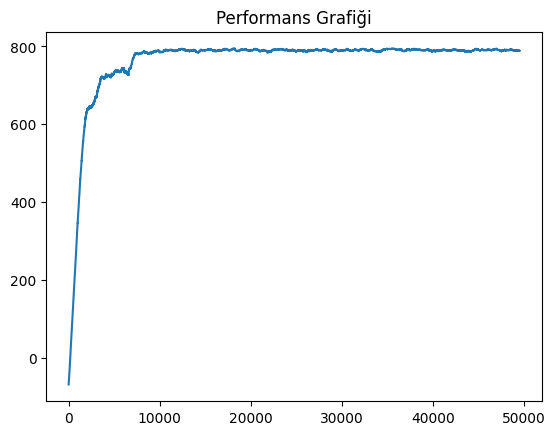

In [6]:
import matplotlib.pyplot as plt

env = CVRPLogisticsEnv()
q_table = {}

alpha = 0.2       # Hızlı öğrenme
gamma = 0.95
epsilon = 1.0
epsilon_decay = 0.9997
min_epsilon = 0.05

def get_state_key(obs):
    return tuple(obs)

history_rewards = []
print("Rota Optimizasyonu Eğitimi Başlıyor...")

episodes = 50000
for episode in range(episodes):
    obs = env.reset()
    state = get_state_key(obs)
    done = False
    total_reward = 0

    while not done:
        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            if state not in q_table: q_table[state] = np.zeros(env.action_space.n)
            action = np.argmax(q_table[state])

        next_obs, reward, done, _ = env.step(action)
        next_state = get_state_key(next_obs)

        if state not in q_table: q_table[state] = np.zeros(env.action_space.n)
        if next_state not in q_table: q_table[next_state] = np.zeros(env.action_space.n)

        old_value = q_table[state][action]
        next_max = np.max(q_table[next_state])

        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state][action] = new_value

        state = next_state
        total_reward += reward

    history_rewards.append(total_reward)
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    if episode % 5000 == 0:
        print(f"Episode: {episode} | Puan: {total_reward:.1f} | Epsilon: {epsilon:.3f}")

print("✅ Eğitim Bitti!")

# Hızlıca grafiğe de bakalım
plt.plot(np.convolve(history_rewards, np.ones(500)/500, mode='valid'))
plt.title("Performans Grafiği")
plt.show()

In [7]:
obs = env.reset()
state = get_state_key(obs)
done = False
total_reward = 0

print("ROBOT İŞ BAŞINDA...")
time.sleep(1)

while not done:
    clear_output(wait=True)
    env.render()

    if state in q_table:
        action = np.argmax(q_table[state])
    else:
        action = env.action_space.sample()

    obs, reward, done, _ = env.step(action)
    state = get_state_key(obs)
    total_reward += reward

    time.sleep(0.15)

clear_output(wait=True)
env.render()
print(f"\nTOPLAM PUAN: {total_reward:.1f}")
print("GÖREV TAMAMLANDI! 🚀")


--- ROTA OPTİMİZASYONU (CVRP) ---
ROBOT YÜKÜ: [📦 -] [📦 -]
BEKLEYEN SİPARİŞLER: 0
LİSTE: 
------------------------------
🏭. . . . . . . . . . 🤖
. 🧱. . . . . . 🧱. . . 
. . . . . . . . 🧱. . . 
. . . . 🧱🧱. . 🧱. . . 
. . . . 🧱. . 🧱. . . . 
E . . 🧱. D . . . . 🧱. 
. . . 🧱. . 🧱🧱. . . . 
. . . . 🧱. . . . . . . 
. . 🧱. . . . 🧱. 🧱🧱. 
. . . . . 🧱. 🧱. . . . 
. . . . . . 🧱. . . . . 
. . . . . C . . . . . A 

TOPLAM PUAN: 807.5
GÖREV TAMAMLANDI! 🚀


Performans Analizi Yapılıyor... (Robot vs Matematik)

--- SONUÇ RAPORU ---
Ortalama İdeal Adım (BFS): 220.0
Ortalama Ajan Adımı (RL):  246.0
Yol Verimliliği: %89.44
⚠️ BAŞARILI. Robot yolu buluyor ama bazen uzatıyor.


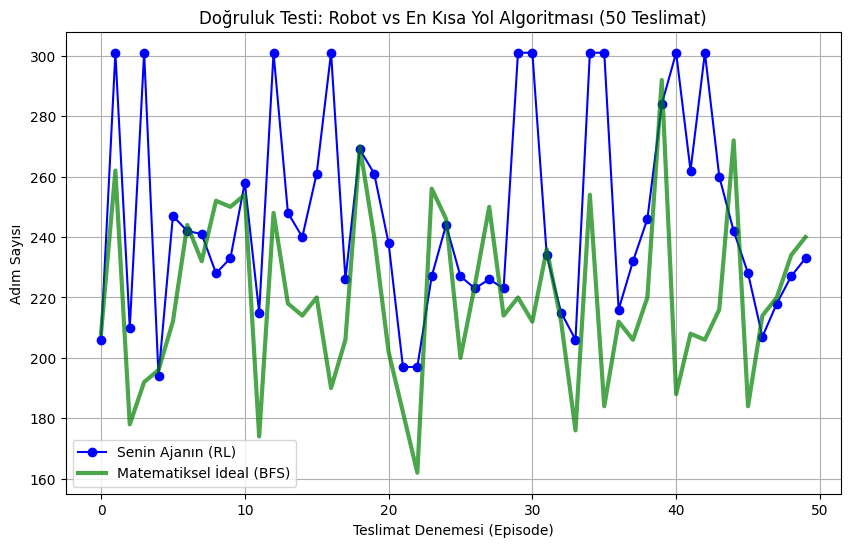

In [8]:
import matplotlib.pyplot as plt
from collections import deque

# --- 1. MATEMATİKSEL HESAPLAYICI (BFS) ---
def bfs_shortest_path(grid_map, start, target_val):
    """Duvarlardan kaçarak iki nokta arasındaki EN KISA mesafeyi ölçer"""
    rows, cols = grid_map.shape
    queue = deque([(start, 0)])
    visited = set()
    visited.add(tuple(start))

    # Hedefin koordinatını bul
    targets = []
    for r in range(rows):
        for c in range(cols):
            if grid_map[r, c] == target_val:
                targets.append((r, c))

    while queue:
        (r, c), dist = queue.popleft()

        # Hedefe vardık mı?
        for tr, tc in targets:
            if r == tr and c == tc:
                return dist

        # Komşulara bak
        for dr, dc in [(-1,0), (1,0), (0,-1), (0,1)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < rows and 0 <= nc < cols:
                if grid_map[nr, nc] != 1 and (nr, nc) not in visited:
                    visited.add((nr, nc))
                    queue.append(((nr, nc), dist + 1))
    return 0 # Yol yoksa veya zaten oradaysak

def calculate_ideal_steps(env):
    """Mevcut sipariş listesi için ideal adım sayısını hesaplar (Simülasyon)"""
    # Ortamın kopyasını almayalım, sadece verilerini okuyalım
    sim_pos = [0, 0] # Dock'ta başla
    sim_slots = [0, 0]
    sim_orders = env.order_list.copy()
    total_steps = 0

    # Basit Greedy Strateji (Matematiksel İdeal)
    # 1. Dock'a git, doldur. 2. En yakın teslimata git.

    while len(sim_orders) > 0 or sum(sim_slots) > 0:
        # A) Çanta boşsa veya yer varsa ve sipariş varsa -> DOCK'a git
        if 0 in sim_slots and len(sim_orders) > 0:
            if sim_pos != [0, 0]: # Dock'ta değilse git
                dist = bfs_shortest_path(env.map, sim_pos, 2)
                total_steps += dist
                sim_pos = [0, 0]

            # Yükle
            while 0 in sim_slots and len(sim_orders) > 0:
                empty_idx = sim_slots.index(0)
                sim_slots[empty_idx] = sim_orders.pop(0)

        # B) Teslimat -> En yakın rafa git
        elif sum(sim_slots) > 0:
            # Çantadaki ürünlerin raflarını bul
            targets = []
            if sim_slots[0] > 0: targets.append((sim_slots[0], env.shelves[sim_slots[0]]))
            if sim_slots[1] > 0: targets.append((sim_slots[1], env.shelves[sim_slots[1]]))

            # Şu anki konuma en yakın olan hedefi seç
            best_dist = 9999
            best_target_pos = None
            best_item_idx = -1

            for item_val, pos in targets:
                # Rafın harita değeri: 10 + (item-1)
                shelf_map_val = 10 + (item_val - 1)
                d = bfs_shortest_path(env.map, sim_pos, shelf_map_val)
                if d < best_dist:
                    best_dist = d
                    best_target_pos = pos
                    # Bu item hangi slotta?
                    if sim_slots[0] == item_val: best_item_idx = 0
                    else: best_item_idx = 1

            # Oraya git
            total_steps += best_dist
            sim_pos = list(best_target_pos)
            sim_slots[best_item_idx] = 0 # Bırak

    return total_steps

# --- 2. KARŞILAŞTIRMA TESTİ ---
print("Performans Analizi Yapılıyor... (Robot vs Matematik)")
test_episodes = 50
agent_scores = []
math_scores = []

for i in range(test_episodes):
    obs = env.reset() # Yeni harita ve siparişler üretilir
    state = get_state_key(obs)
    done = False
    agent_steps = 0

    # 1. Önce bu harita için MATEMATİKSEL İDEALİ hesapla
    # (Environment resetlendiği an elindeki sipariş listesine göre hesap yapar)
    ideal_steps = calculate_ideal_steps(env)
    math_scores.append(ideal_steps)

    # 2. Şimdi AJANI yarıştır
    while not done:
        if state in q_table:
            action = np.argmax(q_table[state])
        else:
            action = env.action_space.sample()

        obs, reward, done, _ = env.step(action)
        state = get_state_key(obs)
        agent_steps += 1

        if agent_steps > 300: # Sonsuz döngü koruması
            break

    agent_scores.append(agent_steps)

# --- 3. GRAFİK ÇİZİMİ ---
avg_agent = np.mean(agent_scores)
avg_math = np.mean(math_scores)
efficiency = (avg_math / avg_agent) * 100

print(f"\n--- SONUÇ RAPORU ---")
print(f"Ortalama İdeal Adım (BFS): {avg_math:.1f}")
print(f"Ortalama Ajan Adımı (RL):  {avg_agent:.1f}")
print(f"Yol Verimliliği: %{efficiency:.2f}")

if efficiency > 90:
    print("✅ MÜKEMMEL! Robot neredeyse her seferinde en kısa yolu kullanıyor.")
elif efficiency > 75:
    print("⚠️ BAŞARILI. Robot yolu buluyor ama bazen uzatıyor.")
else:
    print("❌ GELİŞTİRİLMELİ. Robot çok dolaşıyor.")

plt.figure(figsize=(10, 6))
plt.plot(agent_scores, label='Senin Ajanın (RL)', color='blue', marker='o', linestyle='-')
plt.plot(math_scores, label='Matematiksel İdeal (BFS)', color='green', linewidth=3, alpha=0.7)

plt.title(f"Doğruluk Testi: Robot vs En Kısa Yol Algoritması ({test_episodes} Teslimat)")
plt.xlabel("Teslimat Denemesi (Episode)")
plt.ylabel("Adım Sayısı")
plt.legend()
plt.grid(True)
plt.show()